In [91]:
import multiprocessing as mp
from functools import reduce

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional
import copy
import gc
import multiprocessing as mp

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')

In [4]:
def time_indexed_df(df1: pd.core.frame.DataFrame, columname: str) -> pd.core.frame.DataFrame:
    """ 
        Cast into a time-indexed dataframe.
        df1 paramater should have a column containing datetime-like data,
        which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
        or a string containing a compatible datetime (i.e. pd.to_datetime)
    """
    
    _tmp = df1.copy()
    
    pool = mp.Pool()
    _tmp[columname] = pool.map(pd.to_datetime, _tmp[columname])
    pool.close()
    pool.terminate()
    
    _tmp.index = _tmp[columname]
    _tmp.drop(columname, axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    
    return _tmp
##

def dist_plot(series: pd.core.series.Series, dropna: bool = True) -> NoReturn:
    """
    """
    
    if dropna:
        series = series.dropna()
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_box.set(xlabel='')
##


In [5]:
hba1c = lambda x: (x + 105) / 36.5

In [9]:
x = pd.read_csv('data/CareLink-Export-16-mar-2020.csv')
x["DateTime"] =  x["Date"] + " " + x["Time"]
x.drop(["Date", "Time"], axis=1, inplace=True)

/usr/local/anaconda3/envs/diab/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,8,9,10,13,14,16,17,18,34,37,39,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
y = time_indexed_df(x, 'DateTime')
y['hour'] = y.index.hour

In [11]:
# Deltas within minutes
for i in range(1, 11):
    y[f'd{i}'] = y['Sensor Glucose (mg/dL)'].diff(i)

In [12]:
whole = y.copy()

In [13]:
whole['ISIG Value'].dropna().count(), whole['Sensor Glucose (mg/dL)'].dropna().count()

(14322, 14322)

We can perform regression ! 

In [14]:
bg_idx = whole['BG Reading (mg/dL)'].dropna().index
whole.loc[
    bg_idx - dt.timedelta(minutes=10) : bg_idx + dt.timedelta(minutes=10)
    , 'Sensor Glucose (mg/dL)'
]

TypeError: Cannot convert input [DatetimeIndex(['2020-01-20 22:45:12', '2020-01-21 00:16:35',
               '2020-01-21 06:07:02', '2020-01-21 09:22:02',
               '2020-01-21 12:05:07', '2020-01-21 14:37:55',
               '2020-01-21 15:34:02', '2020-01-21 19:09:38',
               '2020-01-21 19:09:38', '2020-01-21 22:53:30',
               ...
               '2020-03-15 20:21:38', '2020-03-15 21:07:39',
               '2020-03-16 07:17:07', '2020-03-16 07:17:07',
               '2020-03-16 17:47:46', '2020-03-16 19:02:13',
               '2020-03-16 20:31:20', '2020-03-16 21:54:15',
               '2020-03-16 22:21:32', '2020-03-16 23:18:32'],
              dtype='datetime64[ns]', name='DateTime', length=320, freq=None)] of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'> to Timestamp

In [15]:
hba1c(whole['Sensor Glucose (mg/dL)'].dropna().mean())

7.024202634896405

In [18]:
y = y.loc['2020-03-01':, :]

In [19]:
hba1c(y['Sensor Glucose (mg/dL)'].dropna().mean())

7.0321433673550375

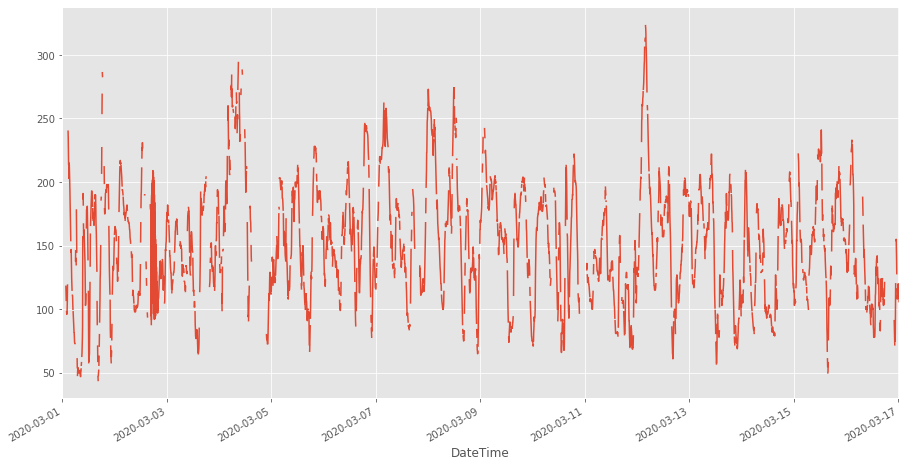

In [20]:
y['Sensor Glucose (mg/dL)'].plot()

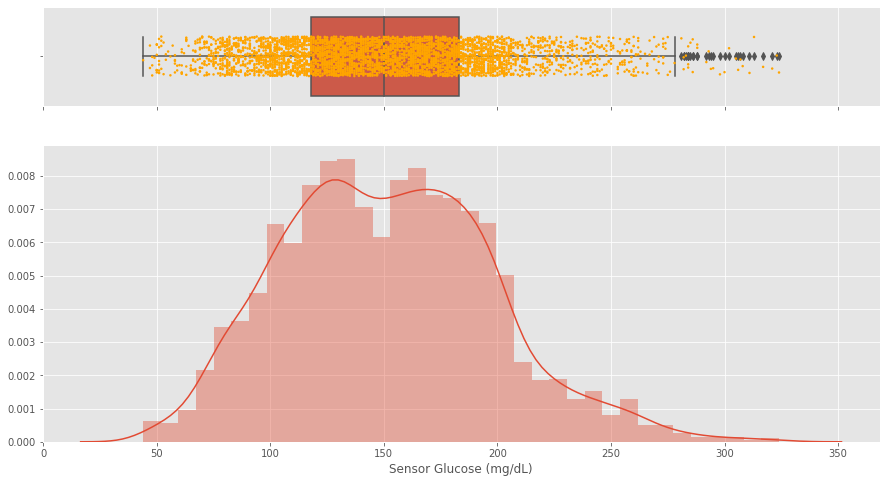

In [21]:
dist_plot(y['Sensor Glucose (mg/dL)'])

In [22]:
y.columns

Index(['Index', 'New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'P

In [23]:
keyword = 'SUSPEND BEFORE LOW'
alarms  = []
for i in y.Alarm.dropna().unique().tolist():
    if keyword in i:
        alarms.append(i)
alarms

['SUSPEND BEFORE LOW ALARM, QUIET',
 'SUSPEND BEFORE LOW ALARM, PATIENT UNRESPONSIVE, MEDICAL DEVICE EMERGENCY']

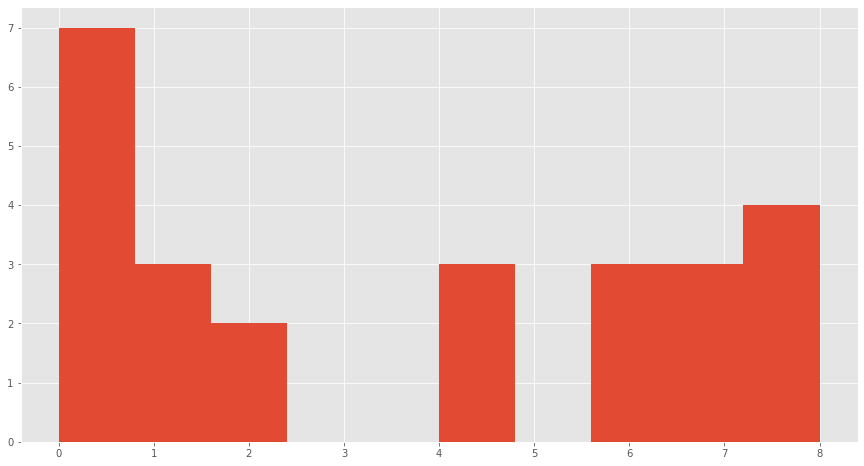

In [24]:
y[ y.Alarm == 'SUSPEND BEFORE LOW ALARM, QUIET' ].hour.hist()

In [46]:
#meal_id = y['BWZ Carb Input (grams)'].dropna().index
nonull_meals = y['BWZ Carb Input (grams)'].dropna()
nonull_meals = nonull_meals[ nonull_meals > 0 ]
meal_id = nonull_meals.index
print(len(meal_id))

71


In [116]:
y.shape, y.drop_duplicates().shape

((6764, 56), (6764, 56))

In [56]:
# df.drop(df.loc[x:y].index, inplace=True)
basal = y.copy()
for uid in meal_id:
    if uid+dt.timedelta(hours=2, minutes=40) in basal.index:
        basal.drop(basal.loc[uid:(uid+dt.timedelta(hours=2, minutes=40))].index, inplace=True)

In [123]:
whole.index.get_loc(meal_id[0]), y.index.get_loc(meal_id[0]), basal.index.get_loc(meal_id[0])

(slice(15871, 15874, None), slice(252, 255, None), slice(252, 255, None))

In [134]:
basal = y.copy()
for uid in meal_id:
    real = uid+dt.timedelta(hours=2, minutes=30)
    #closest = y.index[y.index.get_loc(real, method='nearest')]
    #print(y.index.get_loc(uid, method='nearest'))
    closest = y.index[y.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
    #print(f"real : {real}, closest : {y.index[closest]}, closest-1 : {y.index[closest-1]}")
    basal.loc[uid:closest, 'Sensor Glucose (mg/dL)'] = np.nan
    #basal.drop(basal.loc[uid:closest].index, inplace=True)

In [67]:
y.shape[0] - basal.shape[0] 

45

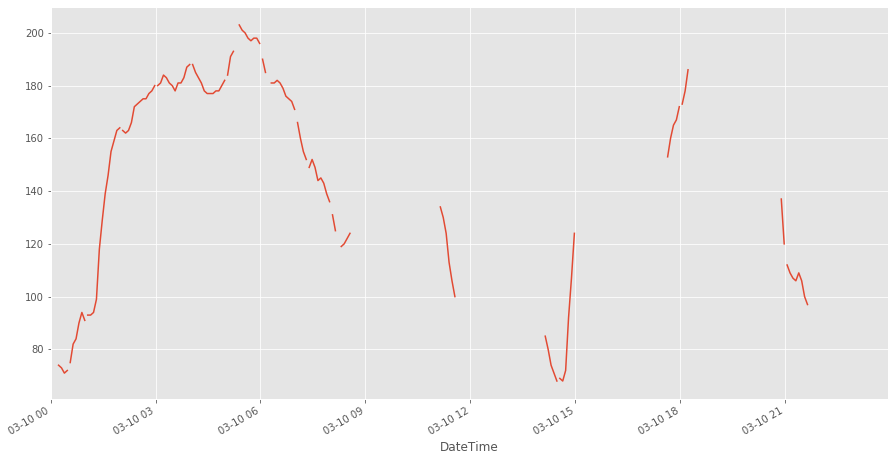

In [135]:
basal.loc['2020-03-10', 'Sensor Glucose (mg/dL)'].plot()

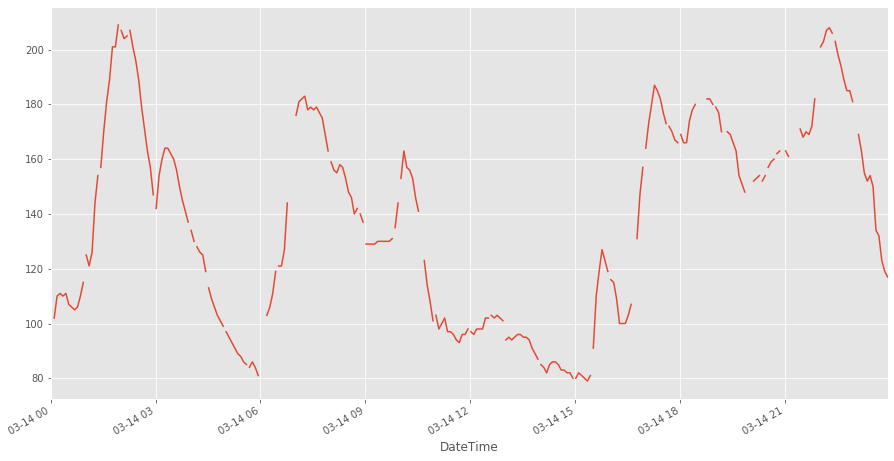

In [137]:
#y.loc['2020-03-14', 'Sensor Glucose (mg/dL)'].interpolate().plot()
#y.loc['2020-03-14', 'Sensor Glucose (mg/dL)'].interpolate(method='akima').plot()
y.loc['2020-03-14', 'Sensor Glucose (mg/dL)'].plot()

In [90]:
abs(dt.timedelta(hours=1) - dt.timedelta(hours=2))

datetime.timedelta(seconds=3600)

In [26]:
y.loc[meal_id, 'BWZ Carb Ratio (g/U)'].dropna().index ==  meal_id

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [27]:
dt10 = dt.timedelta(minutes=10)
dtpost_low = dt.timedelta(hours=1, minutes=40)
dtpost_high = dt.timedelta(hours=2, minutes=20)

In [28]:
meal_descriptive = pd.core.frame.DataFrame({
    'hour': meal_id.hour, 
    'pre prandial': [ 
        y.loc[ meal - dt10 : meal + dt10,  'Sensor Glucose (mg/dL)' ].dropna().mean()
        for meal in meal_id
    ],
    'post mean': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().mean() 
        for meal in meal_id
    ],
    'post std': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().std() 
        for meal in meal_id
    ], 
    'post min': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().min() 
        for meal in meal_id
    ],
    'post max': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().max() 
        for meal in meal_id
    ],
}, index=meal_id)

meal_descriptive['delta'] = meal_descriptive['post mean'] - meal_descriptive['pre prandial'] 
meal_descriptive['ratio'] = y.loc[meal_id, 'BWZ Carb Ratio (g/U)'].dropna()

In [29]:
meal_descriptive.loc[  meal_descriptive.hour < 6, 'meal' ] = 'night'
meal_descriptive.loc[ (meal_descriptive.hour >= 6)  & (meal_descriptive.hour < 9), 'meal'  ] = 'breakfast'
meal_descriptive.loc[ (meal_descriptive.hour >= 9)  & (meal_descriptive.hour < 12), 'meal' ] = 'lunch'
meal_descriptive.loc[ (meal_descriptive.hour >= 12) & (meal_descriptive.hour < 19), 'meal' ] = 'afternoon'
meal_descriptive.loc[ (meal_descriptive.hour >= 19) & (meal_descriptive.hour < 24), 'meal' ] = 'dinner'

In [30]:
meal_descriptive.head()

,hour,pre prandial,post mean,post std,post min,post max,delta,ratio,meal
DateTime,,,,,,,,,
2020-03-01 14:14:54,14,172.50,77.250,29.605743,44.0,130.0,-95.250,12.0,afternoon
2020-03-01 17:49:28,17,173.00,185.625,8.140507,175.0,194.0,12.625,12.0,afternoon
2020-03-01 19:25:28,19,191.25,169.000,26.164316,130.0,198.0,-22.250,18.0,dinner
2020-03-01 22:57:47,22,93.75,149.750,11.196300,136.0,162.0,56.000,18.0,dinner
2020-03-02 01:36:59,1,126.00,197.375,5.449443,191.0,206.0,71.375,12.0,night


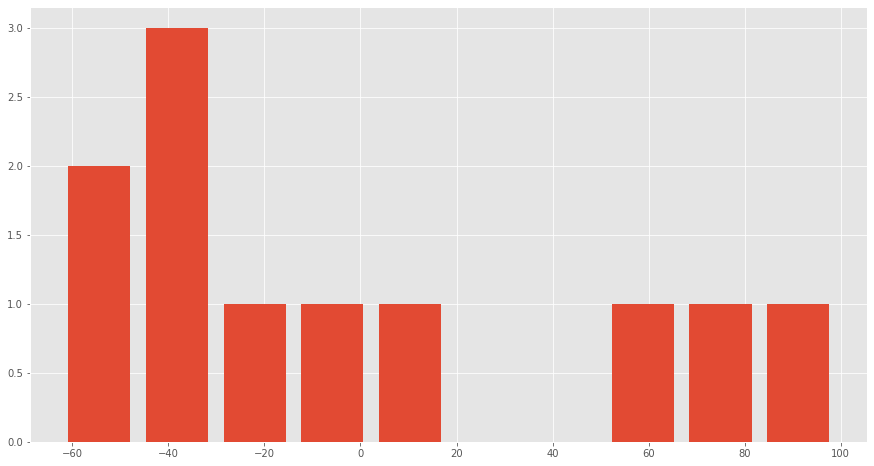

In [31]:
meal_descriptive[ meal_descriptive.meal ==  'lunch' ].delta.hist(rwidth=0.8)

In [32]:
print(meal_descriptive[ meal_descriptive.meal == 'dinner'].describe())

            hour  pre prandial   post mean   post std    post min    post max  \
count  21.000000     18.000000   18.000000  18.000000   18.000000   18.000000   
mean   21.380952    127.458333  133.958333  10.228222  120.722222  148.555556   
std     1.465476     36.808552   41.451003   7.646826   40.731265   42.541637   
min    19.000000     73.750000   80.250000   1.908627   68.000000   87.000000   
25%    20.000000     98.625000  114.750000   5.391793  106.500000  128.000000   
50%    22.000000    125.000000  128.687500   8.246022  118.500000  138.500000   
75%    22.000000    147.125000  148.156250  11.079633  129.750000  160.750000   
max    23.000000    191.250000  246.750000  26.672618  242.000000  254.000000   

            delta      ratio  
count   17.000000  21.000000  
mean     8.926471  18.190476  
std     54.214293   0.402374  
min    -64.875000  18.000000  
25%    -42.000000  18.000000  
50%      5.375000  18.000000  
75%     55.375000  18.000000  
max    101.500000  19.

In [33]:
meal_descriptive.head()

,hour,pre prandial,post mean,post std,post min,post max,delta,ratio,meal
DateTime,,,,,,,,,
2020-03-01 14:14:54,14,172.50,77.250,29.605743,44.0,130.0,-95.250,12.0,afternoon
2020-03-01 17:49:28,17,173.00,185.625,8.140507,175.0,194.0,12.625,12.0,afternoon
2020-03-01 19:25:28,19,191.25,169.000,26.164316,130.0,198.0,-22.250,18.0,dinner
2020-03-01 22:57:47,22,93.75,149.750,11.196300,136.0,162.0,56.000,18.0,dinner
2020-03-02 01:36:59,1,126.00,197.375,5.449443,191.0,206.0,71.375,12.0,night


In [34]:
column    = 'delta'

print(column, '\n')
for i in set(meal_descriptive.meal):
    _tmp =  meal_descriptive[ meal_descriptive.meal == i ].describe().T
    print(i, '\n', f"Mean: {int(_tmp['mean'][column])}, Std: {int(_tmp['std'][column])}", '\n\n')

delta 

night 
 Mean: -9, Std: 75 


dinner 
 Mean: 8, Std: 54 


lunch 
 Mean: 0, Std: 55 


afternoon 
 Mean: 3, Std: 54 


breakfast 
 Mean: 31, Std: 20 




In [35]:
postp = [
    y.loc[ 
        meal + dt.timedelta(hours=1, minutes=30) : meal + dt.timedelta(hours=3), 
        ['Sensor Glucose (mg/dL)', 'hour', *[f'd{i}' for i in range(1, 11)]] 
    ].dropna()
    for meal in meal_id
]

postp = pd.concat(postp)
postp.rename({
    'Sensor Glucose (mg/dL)': 'post points', 'b': 'Y'
}, axis='columns', inplace=True)

postp.head()

,post points,hour,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10
DateTime,,,,,,,,,,,,
2020-03-01 15:53:58,139.0,15,-6.0,-20.0,-25.0,-29.0,-42.0,-48.0,-51.0,-48.0,-51.0,-48.0
2020-03-01 15:58:58,130.0,15,-9.0,-15.0,-29.0,-34.0,-38.0,-51.0,-57.0,-60.0,-57.0,-60.0
2020-03-01 20:58:58,196.0,20,-1.0,0.0,0.0,-1.0,-1.0,-2.0,0.0,4.0,2.0,3.0
2020-03-02 00:53:59,154.0,0,-6.0,-8.0,-8.0,-9.0,-10.0,-10.0,-11.0,-10.0,-8.0,-5.0
2020-03-02 17:58:59,204.0,17,74.0,-4.0,70.0,-4.0,69.0,-5.0,69.0,-2.0,65.0,2.0


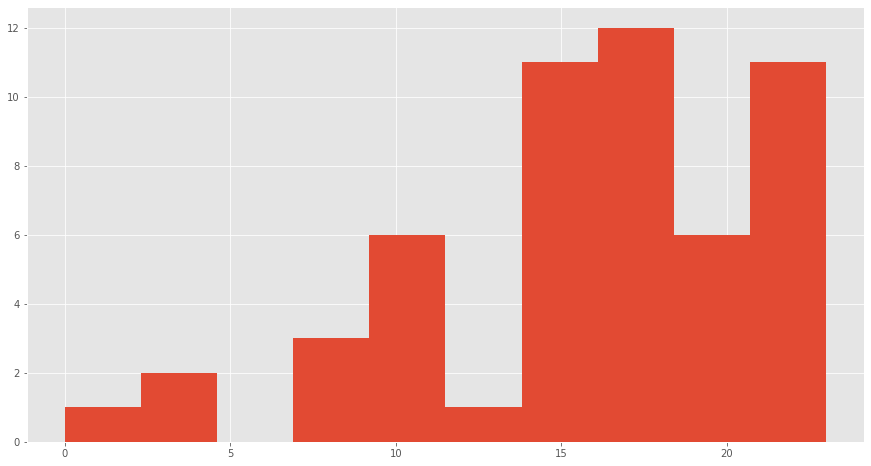

In [36]:
postp.hour.hist()

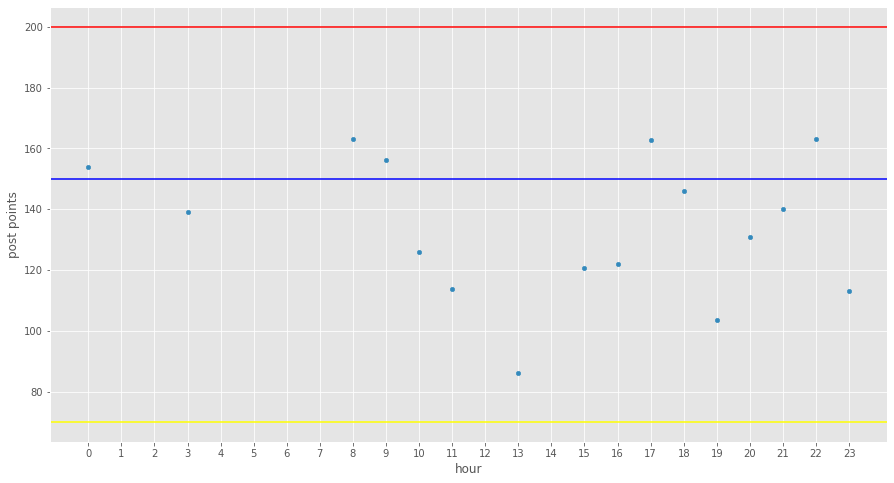

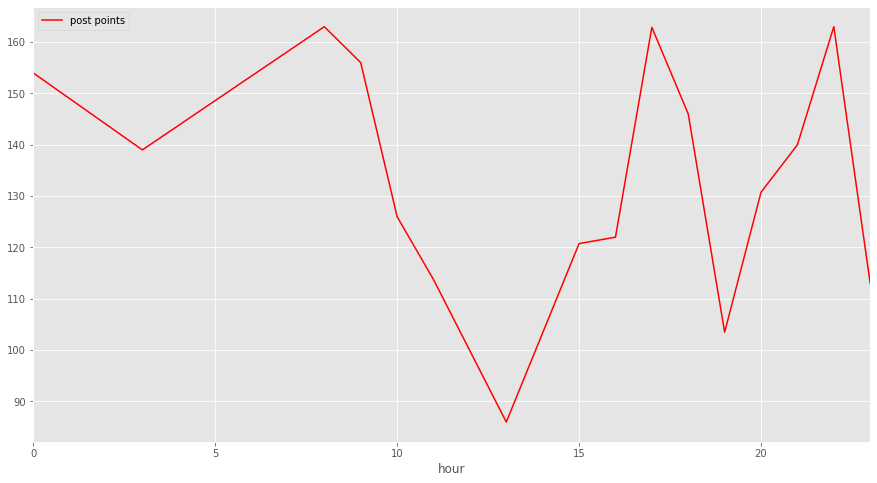

In [37]:
postp.groupby(postp.index.hour).mean().plot(
    x='hour', y='post points', kind='scatter', grid=True, xticks=list(range(24))
)
plt.axhline(150, color='blue')
plt.axhline(200, color='red')
plt.axhline(70, color='yellow')
postp.groupby(postp.index.hour).mean().plot(x='hour', y='post points', color='red')

In [38]:
y.groupby('hour')['Sensor Glucose (mg/dL)'].mean()

hour
0     145.605714
1     158.212291
2     181.031250
3     183.166667
4     177.031746
5     164.280000
6     155.830508
7     143.932961
8     144.068783
9     159.396648
10    166.978610
11    157.174863
12    152.214660
13    134.640625
14    125.203125
15    125.182320
16    125.954545
17    145.589474
18    161.913907
19    163.810127
20    159.018182
21    139.006024
22    126.615819
23    144.077778
Name: Sensor Glucose (mg/dL), dtype: float64

In [112]:
hourly_mean = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).mean()
hourly_std  = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).std()

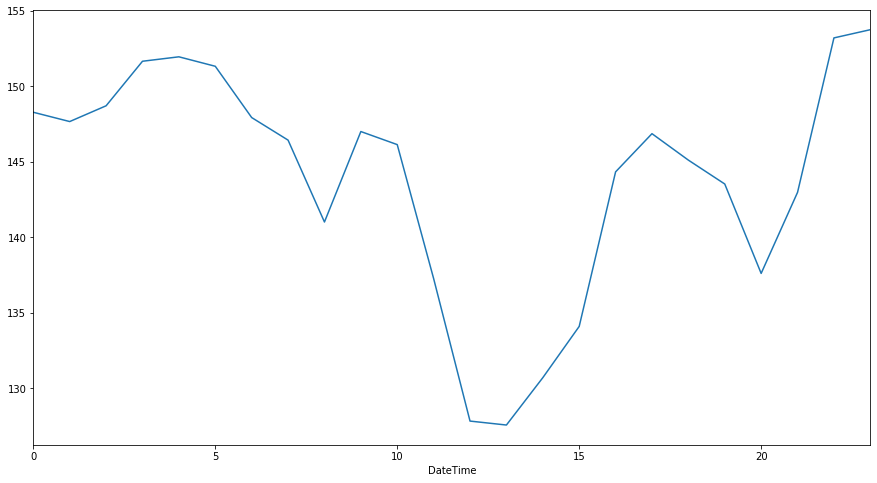

In [28]:
hourly_mean.plot()

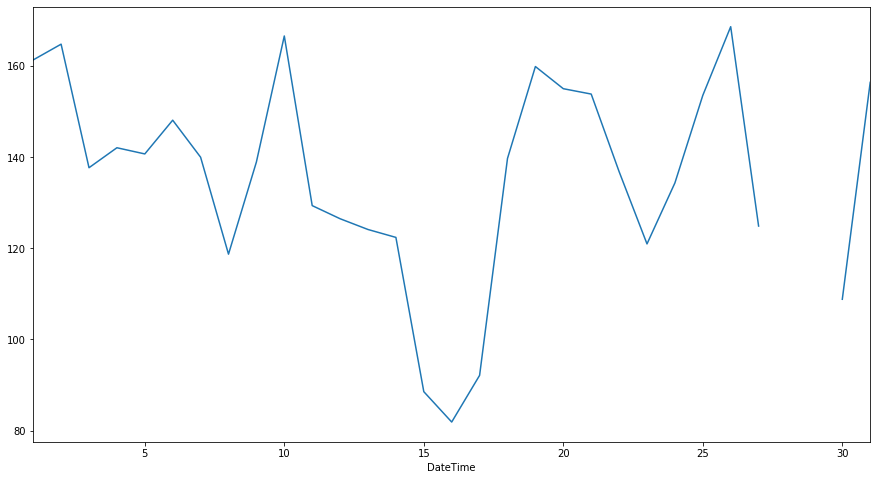

In [13]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.day).mean().plot()

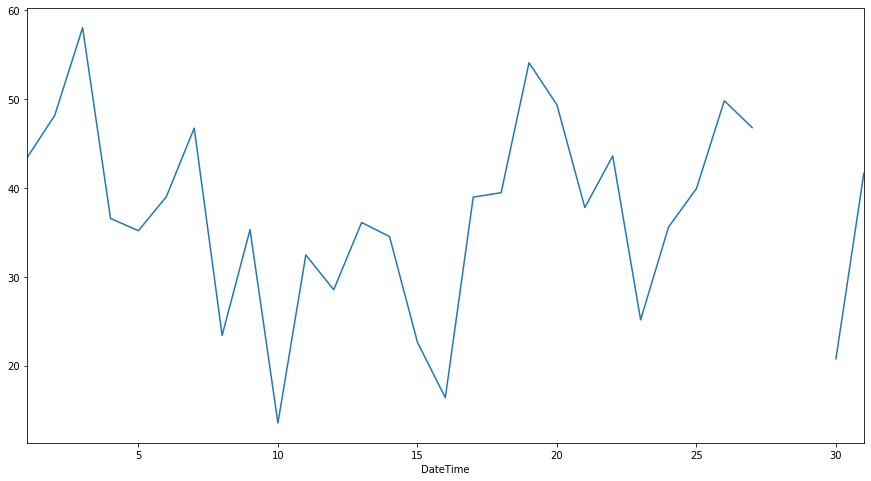

In [14]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.day).std().plot()

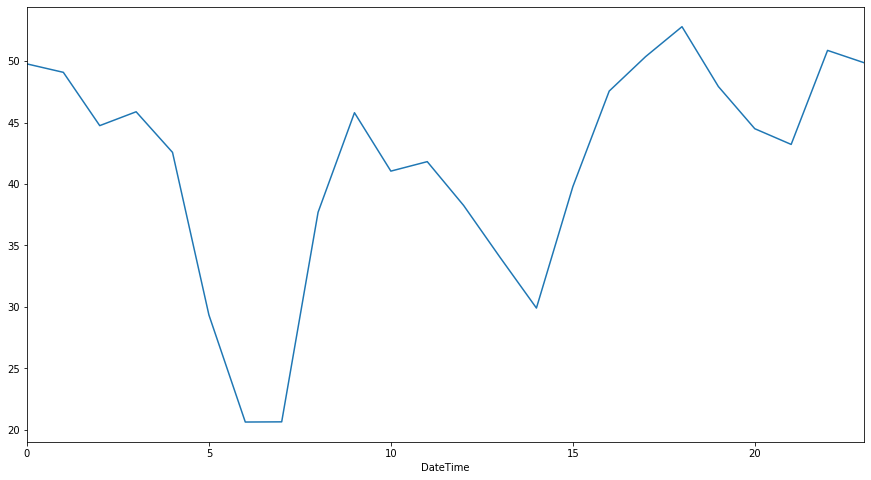

In [15]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).std().plot()

In [16]:
hourly_std.apply(lambda x: x/hourly_std.shape[0])

DateTime
0     2.073550
1     2.044991
2     1.864391
3     1.911366
4     1.773769
5     1.222983
6     0.860092
7     0.860734
8     1.570875
9     1.908137
10    1.710272
11    1.742381
12    1.593854
13    1.418132
14    1.246334
15    1.657384
16    1.981485
17    2.098222
18    2.199657
19    1.996871
20    1.853964
21    1.800740
22    2.119320
23    2.077687
Name: Sensor Glucose (mg/dL), dtype: float64

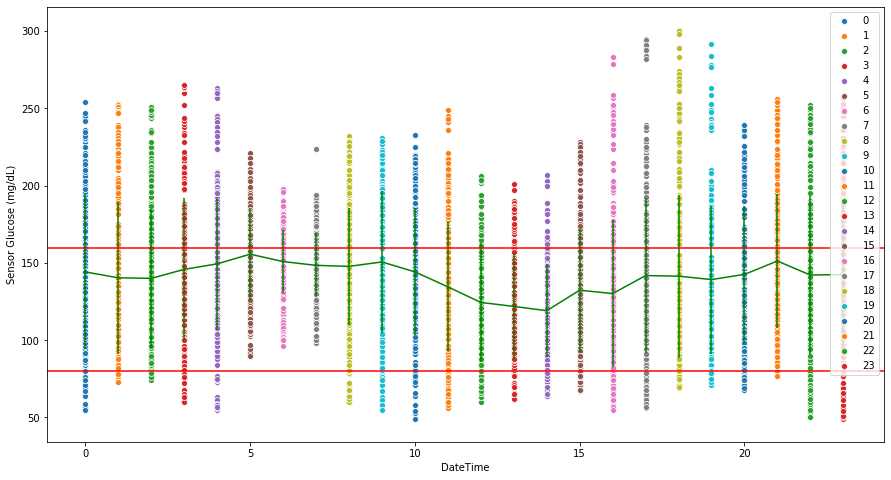

In [17]:
by_hour = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour)
for i in by_hour:
    sns.scatterplot(i[1].dropna().index.hour, i[1].dropna(), label=f"{i[0]}")
    
plt.errorbar(
    hourly_mean.index, 
    hourly_mean.to_list(), 
    yerr=hourly_std.apply(lambda x: x).to_list(),
    c='green'
)

plt.axhline(160, c='red')
plt.axhline(80, c='red')

In [18]:
z = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour)

In [19]:
for i in z:
    pass
    #sns.scatterplot(i[1].dropna().index.hour, i[1].dropna())
    #print(i[1].dropna())
    #plt.figure()
    #plt.title(f"Hour {i[0]}")
    #sns.distplot(i[1].dropna())

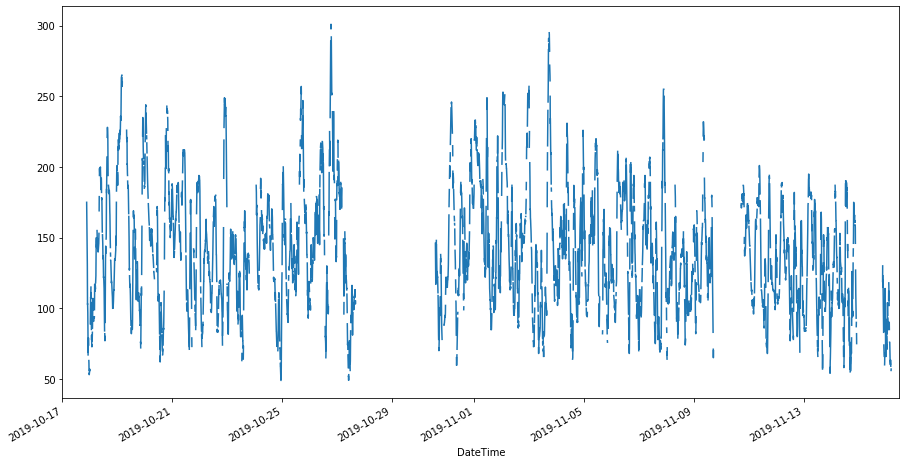

In [20]:
y['Sensor Glucose (mg/dL)'].plot()

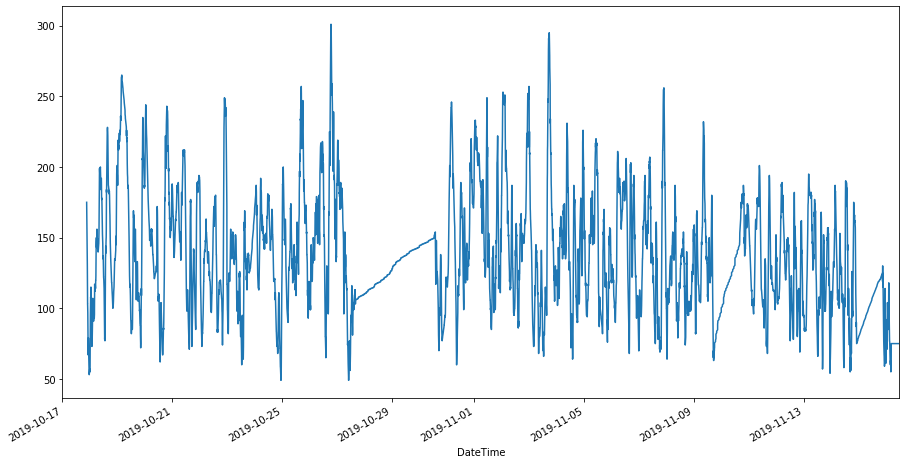

In [21]:
y['Sensor Glucose (mg/dL)'].interpolate().plot()

In [161]:
df = y['Sensor Glucose (mg/dL)']
df[np.bitwise_not(df.index.duplicated())]

DateTime
2019-10-17 00:00:00   NaN
2019-10-17 01:00:00   NaN
2019-10-17 01:11:00   NaN
2019-10-17 01:12:00   NaN
2019-10-17 02:00:00   NaN
                       ..
2019-11-16 10:50:46   NaN
2019-11-16 11:00:00   NaN
2019-11-16 11:09:43   NaN
2019-11-16 11:14:00   NaN
2019-11-16 11:46:13   NaN
Name: Sensor Glucose (mg/dL), Length: 9416, dtype: float64

In [174]:
time_series = y['Sensor Glucose (mg/dL)']
time_series =  time_series[~df.index.duplicated()].interpolate()
print(time_series.dropna().head(), '\n\n', y['Sensor Glucose (mg/dL)'].dropna())
#time_series.plot()
#decomp = seasonal_decompose(time_series)

DateTime
2019-10-17 21:15:55    169.0
2019-10-17 21:20:55    164.0
2019-10-17 21:25:55    158.0
2019-10-17 21:30:55    152.0
2019-10-17 21:35:55    143.0
Name: Sensor Glucose (mg/dL), dtype: float64 

 DateTime
2019-10-17 21:10:55    175.0
2019-10-17 21:15:55    169.0
2019-10-17 21:20:55    164.0
2019-10-17 21:25:55    158.0
2019-10-17 21:30:55    152.0
                       ...  
2019-11-16 04:17:47     55.0
2019-11-16 04:22:47     58.0
2019-11-16 04:27:47     56.0
2019-11-16 04:32:47     57.0
2019-11-16 04:37:47     75.0
Name: Sensor Glucose (mg/dL), Length: 6800, dtype: float64


In [148]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, freq=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages
    
    Parameters
    ----------
    x : array-like
        Time series. If 2d, individual series are in columns.
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by two_sided.
    freq : int, optional
        Frequency of the series. Must be used if x is not a pandas object.
        Overrides default periodicity of x if x is a pandas
        object with a timeseries index.
    two_sided : bool
        The moving average method used in filtering.
        If True (default), a centered moving average is computed using the filt.
        If F